# Objective

Here, the goal is to perform the data preparation, exploratory data analysis (EDA) and the model tuning and selection with the feature importance on the breast cancer dataset obtained from Kaggle.

In this dataset, several tumor characteristics such as area, symmetry, texture and measured for patients who have been diagnosed with a malignant tumor (M) or not (benign - B). We want to create a model that is able to predict accurately the diagnosis with the relevant features.

Three classification models are tested: LogisticRegression, Random Forest Classifier and XGBoost.

# Data

The breast cancer dataset can be downloaded from Kaggle at this URL : https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset

# Main results

The best model, according to ROC AUC value obtained on the test dataset, is the Logistic Regression model with these parameters values: 'C': 10, 'penalty': 'l1', 'solver': 'liblinear'. The ROC AUC value obtained on the test dataset is equal to 0.98. 

This model will be used for training in a separate python script before deployment.

The area of the tumor is the feature that drives the classification between malignant and benign for this dataset. 

A cleaned and normalized version of breast cancer dataset is exported for further usage.

# Notebook

## Imports

In [86]:
import pandas as pd
from skimpy import skim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from typing import Tuple
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

In [87]:
# I use this to display all columns
pd.set_option('display.max_columns', None)

## Functions

In [88]:
def separate_target_from_features(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_name: str,
    log_transformation: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, np.array, np.array, np.array]:
    """
    From the three datasets (pandas dataframes, train, validation and test) containing all features and the
    target column, separate features and target to return three pandas dataframes containing only features and
    three numpy arrays containing target values. The target is selected according to the provided target_name.

    Args:
        train_df: pandas dataframe containing all training features and target values
        val_df: pandas dataframe containing all validation features and target values
        test_df: pandas dataframe containing all test features and target values

    Returns:
        train: pandas dataframe containing only features values for training dataset
        val: pandas dataframe containing only features values for validation dataset
        test: pandas dataframe containing only features values for test dataset
        y_train: numpy array containing train target values
        y_val: numpy array containing validation target values
        y_test: numpy array containing test target values
    """

    # Select the target values from original datasets
    y_train = train_df[target_name]
    y_val = val_df[target_name]
    y_test = test_df[target_name]

    # If the target value should be log transformed:
    if log_transformation:
        y_train = np.log1p(y_train)
        y_val = np.log1p(y_val)
        y_test = np.log1p(y_test)

    # Remove the target column from features dataset
    del train[target_name]
    del val[target_name]
    del test[target_name]

    return train, val, test, y_train, y_val, y_test

## Data loading

In [89]:
breast_cancer_df = pd.read_csv('data/breast_cancer.csv')

In [90]:
breast_cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Data exploration

The data exploration is divided into three parts:
- First, a brief overview of the dataset using the skimpy library (potential missing values, types of variables, range of values)
- Second, the target is examined with its potential correlations with the features
- Finally, the feature importance is studied

### Dataset overview

First, let's see which columns are present in the dataset:

In [91]:
breast_cancer_df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

- The id column corresponds to patient id
- The diagnosis column is our target variable: we want to determine the diagnosis of the tumor based on its characteristics

For features, a complete description is available on [Kaggle](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset).

In [92]:
# Cleaning of the columns names: replace spaces by underscores and lower the values if needed
breast_cancer_df.columns = breast_cancer_df.columns.str.lower().str.replace(' ', '_')

In [93]:
breast_cancer_df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

Here I isolate the features in a list of features:

In [94]:
features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

***

First, let's explore quickly the dataset:

In [95]:
# Explore quickly the dataset using skimpy library
skim(breast_cancer_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 569    │ │ float64     │ 30    │                                                          │
│ │ Number of columns │ 32     │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name  ┃ NA ┃ NA % ┃ mean     ┃ sd        ┃ p0      ┃ p25    ┃ p50    ┃ p75     ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ id           │  0 │    0 │ 30000000 │ 130000000 │    8700 │ 870000 │ 910000 │ 8800000 │ 910000000 │   ▇    │  │
│ │ radius_mean  │  0 │    0 │       14 │       3.5 │       7 │     12 │     13 │      16 │        28 │  ▂▇▃▂  │  │
│ │ texture_mean │  0 │    0 │       19 │       4.3 │     9.7 │     16 │     19 │      22 │        39 │  ▂▇▆▂  │  │
│ │ perimeter_me │  0 │    0 │       92 │        24 │      44 │     75 │     86 │     100 │       190 │  ▂▇▃▂  │  │
│ │ an           │    │      │          │           │         │        │        │         │           │        │  │
│ │ area_mean    │  0 │    0 │      650 │       350 │     140 │    420 │    550 │     780 │      2500 │  ▇▆▂▁  │  │
│ │ smoothness_m │  0 │    0 │    0.096 │     0.014 │   0.053 │  0.086 │  0.096 │    0.11 │      0.16 │   ▅▇▃  │  │
│ │ ean          │    │      │          │           │         │        │        │         │           │        │  │
│ │ compactness_ │  0 │    0 │      0.1 │     0.053 │   0.019 │  0.065 │  0.093 │    0.13 │      0.35 │  ▇▇▃▁  │  │
│ │ mean         │    │      │          │           │         │        │        │         │           │        │  │
│ │ concavity_me │  0 │    0 │    0.089 │      0.08 │       0 │   0.03 │  0.062 │    0.13 │      0.43 │  ▇▃▂▁  │  │
│ │ an           │    │      │          │           │         │        │        │         │           │        │  │
│ │ concave_poin │  0 │    0 │    0.049 │     0.039 │       0 │   0.02 │  0.034 │   0.074 │       0.2 │  ▇▃▃▁  │  │
│ │ ts_mean      │    │      │          │           │         │        │        │         │           │        │  │
│ │ symmetry_mea │  0 │    0 │     0.18 │     0.027 │    0.11 │   0.16 │   0.18 │     0.2 │       0.3 │ ▁▇▇▂▁  │  │
│ │ n            │    │      │          │           │         │        │        │         │           │        │  │
│ │ fractal_dime │  0 │    0 │    0.063 │    0.0071 │    0.05 │  0.058 │  0.062 │   0.066 │     0.097 │  ▅▇▃▁  │  │
│ │ nsion_mean   │    │      │          │           │         │        │        │         │           │        │  │
│ │ radius_se    │  0 │    0 │     0.41 │      0.28 │    0.11 │   0.23 │   0.32 │    0.48 │       2.9 │   ▇▁   │  │
│ │ texture_se   │  0 │    0 │      1.2 │      0.55 │    0.36 │   0.83 │    1.1 │     1.5 │       4.9 │  ▇▆▁   │  │
│ │ perimeter_se │  0 │    0 │      2.9 │         2 │    0.76 │    1.6 │    2.3 │     3.4 │        22 │   ▇▁   │  │
│ │ area_se      │  0 │    0 │       40 │        45 │   

In our dataset, a first view shows that:
- We have 569 rows with one rows corresponding to one patient.
- We have 32 columns, which means we have one target variable, one id column and 30 features.
- All features are numerical, with the 30 features being of type float64 and the id column probably corresponding to the column of type int32.
- The target variable is "diagnosis" and is the only string column. We will have to binarize it.
- There are no missing values in this dataset.
- The feature values have very different ranges: using the describe method on the dataframe can help visualize the minimum and maximum values for each

In [96]:
breast_cancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


***

Then, examine the range of values using boxplots. Each feature is examined with a separation between malignant and benign tumor diagnosis.

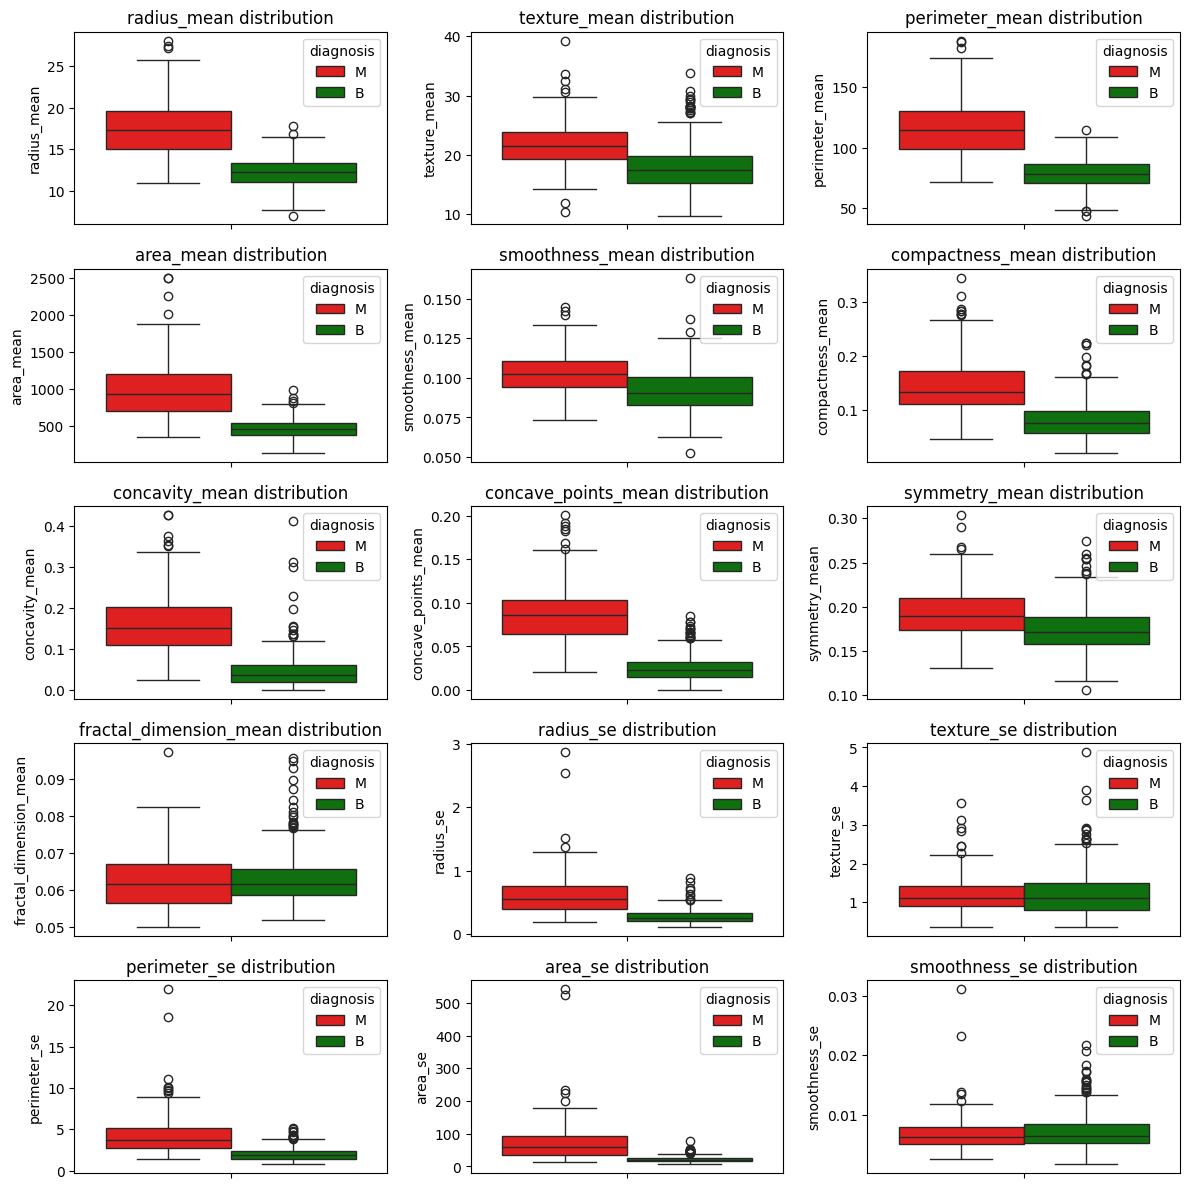

In [97]:
# Examine range of values with boxplots

# Create an array with the colors I will use for the seaborn palette (red for malignant and green for benign)
colors = ["red", "green"]
# Set the custom color palette
sns.set_palette(sns.color_palette(colors))

fig,axes = plt.subplots(5,3, figsize=(12,12), sharex=True)
axes=axes.flatten()

for ax, feature in zip(axes,features):
    sns.boxplot(data=breast_cancer_df, y=feature, hue='diagnosis', ax=ax).set_title(f"{feature} distribution")

plt.tight_layout()  
plt.show()

Generally, the features values for the benign diagnosis seem to be lower that for the malignant diagnosis. 

This is the case for these 13 features:

- radius_mean
- texture_mean
- perimeter_mean
- area_mean
- smoothness_mean
- compactness_mean
- concavity_mean
- concave points_mean
- symmetry_mean
- radius_se
- perimeter_se
- area_se

While this is not the case for these 3 features:

- fractal_dimension
- texture_se
- smoothness_se

<div class="alert-success"> <b>Summary: </b> Malignant tumors have bigger size, higher texture-related values and compactness. 
</div>

***

The relationship between the diagnosis and also between the different features can be explored using pairplots.

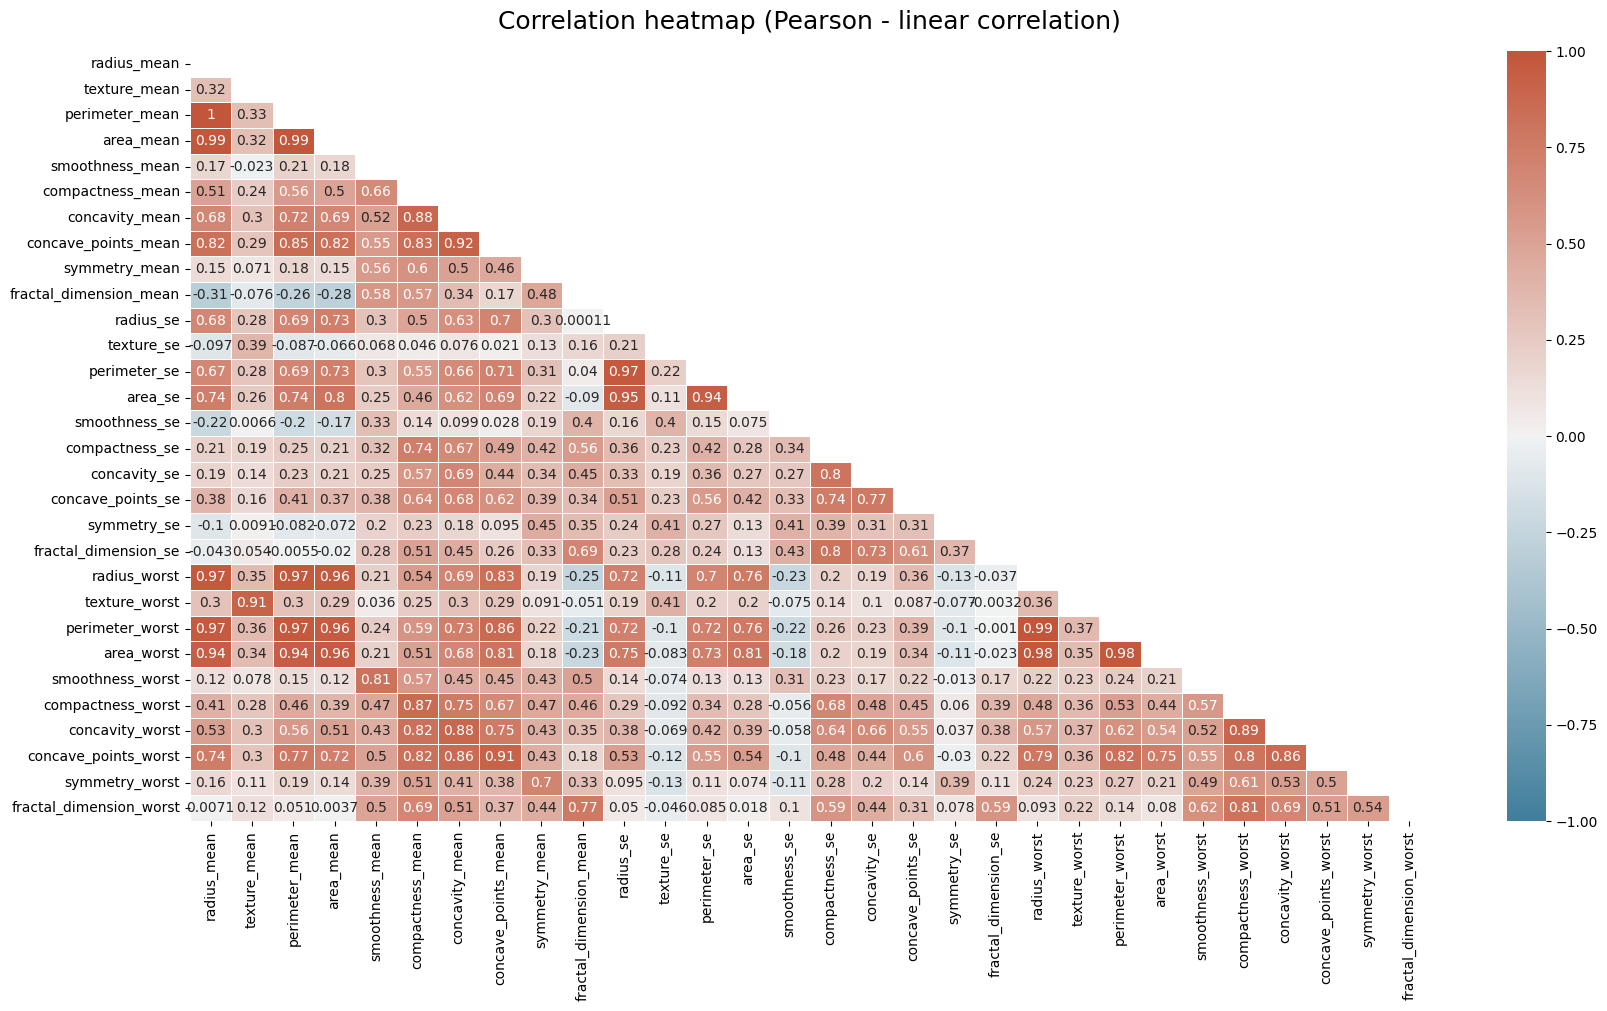

In [98]:
# Select the dataframe without the id column
df_corr = breast_cancer_df.drop(columns='id')

# Set figure size: modify it here or create new function arguments
plt.figure(figsize=(20, 10))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_corr.corr(numeric_only=True), dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

heatmap = sns.heatmap(
    df_corr.corr(numeric_only=True),
    mask=mask,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    annot=True,
    linewidths=0.5,
)
heatmap.set_title('Correlation heatmap (Pearson - linear correlation)', fontdict={"fontsize": 18}, pad=16)
plt.show()

We see that some variables are highly positively correlated (linear correlation): some can be dropped for this analysis.

I decide to keep only one variable that represents highly correlated variables.

<div class="alert-success"> <b>Summary: </b> 
Some highly correlated variables will be discarded for the analysis after Variance Inflation Factor calculation. https://etav.github.io/python/vif_factor_python.html 
</div>

Step 1: run a multiple regression:

In [99]:
# Select the dataframe with the features and the diagnosis columns
df = breast_cancer_df.drop(columns='id')

In [100]:
# Transform the diagnosis column into binary values
df.loc[df["diagnosis"] == "B", "diagnosis"] = 0
df.loc[df["diagnosis"] == "M", "diagnosis"] = 1

In [101]:
%%capture

#gather features
features_corr = "+".join(df[features].columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('diagnosis ~' + features_corr, df, return_type='dataframe')


In [102]:
y

,diagnosis[0],diagnosis[1]
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
564,0.0,1.0
565,0.0,1.0
566,0.0,1.0
567,0.0,1.0


In [103]:
X

,Intercept,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1.0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1.0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1.0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1.0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Step 2: calculate the VIF factors:

In [104]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

Step 3: Inspect VIF Factors

In [105]:
vif.round(1)

,VIF Factor,features
0,1868.2,Intercept
1,3806.1,radius_mean
2,11.9,texture_mean
3,3786.4,perimeter_mean
4,347.9,area_mean
5,8.2,smoothness_mean
6,50.5,compactness_mean
7,70.8,concavity_mean
8,60.0,concave_points_mean
9,4.2,symmetry_mean


We can remove the variables that have the largest VIF values (above 30) and make sure to keep at least one variable of each type (radius, perimeter etc.).

In [106]:
features_to_drop = ["radius_mean", 
                    "perimeter_mean",
                    "area_mean", 
                    "compactness_mean", 
                    "radius_worst", 
                    "perimeter_worst", 
                    "compactness_worst", 
                    "concavity_worst", 
                    "concave_points_worst"]

In [107]:
df = df.drop(columns=features_to_drop)

In [108]:
df.columns

Index(['diagnosis', 'texture_mean', 'smoothness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'texture_worst', 'area_worst',
       'smoothness_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [109]:
new_features = ['texture_mean', 'smoothness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'texture_worst', 'area_worst',
       'smoothness_worst', 'symmetry_worst', 'fractal_dimension_worst']

In [110]:
%%capture

#gather features
features_corr = "+".join(df[new_features].columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('diagnosis ~' + features_corr, df, return_type='dataframe')

In [111]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [112]:
vif.round(1)

,VIF Factor,features
0,317.4,Intercept
1,11.3,texture_mean
2,7.1,smoothness_mean
3,38.0,concavity_mean
4,35.8,concave_points_mean
5,3.9,symmetry_mean
6,7.4,fractal_dimension_mean
7,31.9,radius_se
8,3.9,texture_se
9,29.7,perimeter_se


We can still remove some features with VIF above 10 and keep only one feature of each type when the VIF factors are close.

In [113]:
features_to_drop = ["texture_worst", "concavity_mean", "concave_points_mean", "radius_se", "perimeter_se", "area_se"]

In [114]:
df = df.drop(columns=features_to_drop)

In [115]:
df.columns

Index(['diagnosis', 'texture_mean', 'smoothness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'texture_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'area_worst', 'smoothness_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [116]:
new_features = ['texture_mean', 'smoothness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'texture_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'area_worst', 'smoothness_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [117]:
%%capture

#gather features
features_corr = "+".join(df[new_features].columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('diagnosis ~' + features_corr, df, return_type='dataframe')

In [118]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [119]:
vif.round(1)

,VIF Factor,features
0,221.5,Intercept
1,1.7,texture_mean
2,5.8,smoothness_mean
3,3.5,symmetry_mean
4,7.1,fractal_dimension_mean
5,2.0,texture_se
6,3.2,smoothness_se
7,5.7,compactness_se
8,4.0,concavity_se
9,3.9,concave_points_se


Now, the VIF values are all below 10, which means that our variables are not highly correlated together. The heatmap of Pearson correlation coefficient between them can help to visualize it:

In [120]:
df.columns

Index(['diagnosis', 'texture_mean', 'smoothness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'texture_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'area_worst', 'smoothness_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [121]:
df['diagnosis'] = df['diagnosis'].astype(int)

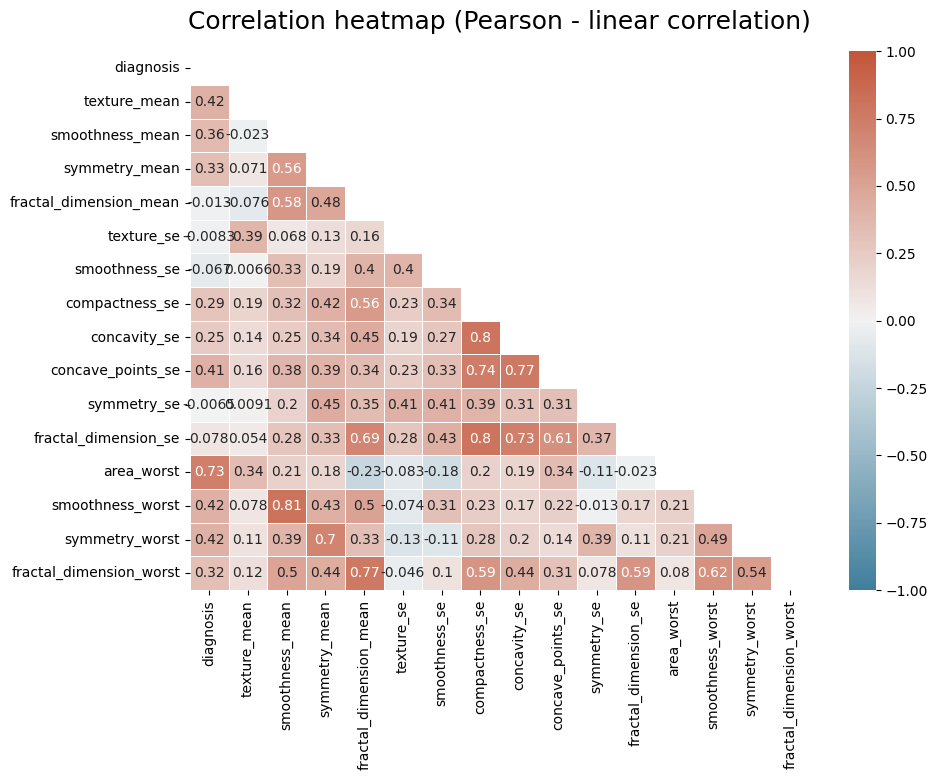

In [122]:
# Set figure size: modify it here or create new function arguments
plt.figure(figsize=(10, 7))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

heatmap = sns.heatmap(
    df.corr(numeric_only=True),
    mask=mask,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    annot=True,
    linewidths=0.5,
)
heatmap.set_title('Correlation heatmap (Pearson - linear correlation)', fontdict={"fontsize": 18}, pad=16)
plt.show()

<div class="alert-success"> <b>Summary: </b> 
After removing very highly correlated features using VIF calculation, we are left with 15 features.
</div>

We can take a look at the target variable 'diagnosis' :

<Axes: xlabel='diagnosis', ylabel='Count'>

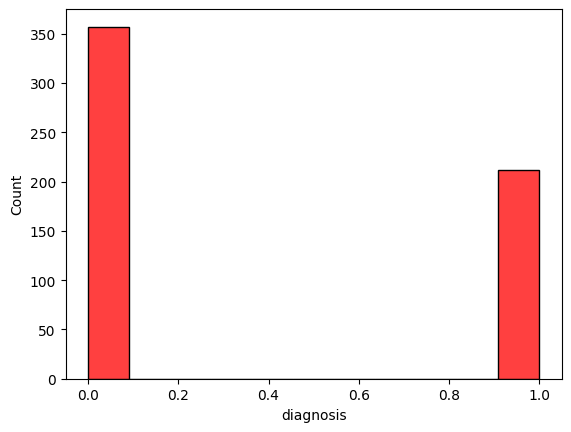

In [123]:
sns.histplot(df['diagnosis'])

The target variable is a bit unbalanced:

In [124]:
print(f"There are {round(sum(df['diagnosis'] == 0)/len(df['diagnosis'])*100,1)}% of benign tumors and {round(sum(df['diagnosis'] == 1)/len(df['diagnosis'])*100,1)}% of malignant tumors in the dataset.")

There are 62.7% of benign tumors and 37.3% of malignant tumors in the dataset.


The diagnosis column is not imbalanced enough to take it into account with resampling methods such as SMOTE, but we keep this information in mind.

## Data normalization

Since each feature has a different range of values, I decide to normalize each column between 0 and 1. This step is important for linear models such as logistic regression, but not for non parametric models such as trees.

In [125]:
features = ['texture_mean', 'smoothness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'texture_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'area_worst', 'smoothness_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [126]:
for feature in features:
    df[feature] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())   

In [127]:
df.head()

,diagnosis,texture_mean,smoothness_mean,symmetry_mean,fractal_dimension_mean,texture_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,area_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst
0,1,0.022658,0.593753,0.686364,0.605518,0.120469,0.159296,0.351398,0.135682,0.300625,0.311645,0.183042,0.450698,0.601136,0.598462,0.418864
1,1,0.272574,0.289880,0.379798,0.141323,0.082589,0.119387,0.081323,0.046970,0.253836,0.084539,0.091110,0.435214,0.347553,0.233590,0.222878
2,1,0.390260,0.514309,0.509596,0.211247,0.094303,0.150831,0.283955,0.096768,0.389847,0.205690,0.127006,0.374508,0.483590,0.403706,0.213433
3,1,0.360839,0.811321,0.776263,1.000000,0.175875,0.251453,0.543215,0.142955,0.353665,0.728148,0.287205,0.094008,0.915472,1.000000,0.773711
4,1,0.156578,0.430351,0.378283,0.186816,0.093065,0.332359,0.167918,0.143636,0.357075,0.136179,0.145800,0.341575,0.437364,0.157500,0.142595


This dataset is exported for further usage.

In [164]:
df.to_csv('clean_breast_cancer_dataset.csv')

# Model tuning and selection

I will apply 3 classification models on the final dataframe:

- Logistic Regression
- Random forest
- XGBoost

## Split into train, test and validation datasets

Here we use a 60%, 20%, 20% for train, validation and tests datasets, respectively.

In [128]:
# First generate the full training dataset and the test dataset
full_train, test = train_test_split(df, test_size=0.2, random_state=42)

In [129]:
# Then separate the full training dataset into train and validation datasets. We have to adjust the proportions:
# we need 20% of the total number of rows from the 80% of values, which means we are looking for 0.25 proportion for the validation dataset
train, val = train_test_split(full_train, test_size=0.25, random_state=42)

In [130]:
# I use a function to separate target from features easily
train, val, test, y_train, y_val, y_test = separate_target_from_features(
    train, val, test, "diagnosis"
)

## Dummy classifier

The dummy classifier will constitute a baseline model to determine if the model results are relevant or not.

In [131]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train, y_train)
dummy_predicted_val = dummy_clf.predict(val)
dummy_clf.score(val, y_val)

0.6140350877192983

In [132]:
roc_auc_score(y_val, dummy_predicted_val)

0.5

In [133]:
# Calculation of the roc auc with the test dataset
dummy_predicted_test = dummy_clf.predict(test)
dummy_roc_auc = roc_auc_score(y_test, dummy_predicted_test)
dummy_roc_auc

0.5

As expected, we obtain a rather low accuracy (0.61) and a ROC AUC value equal to 0.5 with the validation dataset using the DummyClassifier.

## Logistic Regression with hyperparameters tuning

I will perform hyperparameter tuning using GridSearchCV from sklearn library.

In [134]:
# Set the parameters dictionary
parameters = {'solver': ['liblinear'], 'C':[0.01, 0.1, 0.5, 10], 'penalty':['l1', 'l2']}

# Instantiate the model and classifier
log_reg = LogisticRegression()
clf = GridSearchCV(log_reg, parameters)

# Fit
clf.fit(train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 0.5, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']})

In [135]:
# Get the best estimator values
clf.best_estimator_

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [136]:
clf.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

In [137]:
# Get the corresponding accuracy
clf.best_score_

0.9647911338448424

Here we get the best results according to GridSearchCV on the training dataset with C=10, penalty='l1' (liblinear solver). We can check the corresponding AUC with the validation dataset.

In [138]:
log_reg_best = LogisticRegression(C=10, penalty='l1', solver='liblinear')
log_reg_best.fit(train, y_train)

predicted_val = log_reg_best.predict(val)

In [139]:
roc_auc_score(y_val, predicted_val)

0.9629870129870131

The ROC AUC score on validation dataset is very close to the score on training dataset: there is little chance that the model is overfitting. We can confirm the stability of the model with k-fold cross-validation.

In [140]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [141]:
scores = []

for train_idx, val_idx in kfold.split(full_train):
    df_train_kfold = full_train.iloc[train_idx]
    df_val_kfold = full_train.iloc[val_idx]

    y_train_kfold = df_train_kfold["diagnosis"]
    y_val_kfold = df_val_kfold["diagnosis"]

    feature_list = df_train_kfold.columns.values.tolist()
    feature_list.remove("diagnosis")

    model = LogisticRegression(C=10, penalty='l1', solver='liblinear')
    model.fit(df_train_kfold, y_train_kfold)
    y_pred_kfold = model.predict(df_val_kfold)

    auc = roc_auc_score(y_val_kfold, y_pred_kfold)
    scores.append(auc)

print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

1.000 +- 0.000


The standard deviation of ROC AUC scores is equal to 0 after running 5-fold cross-validation on our dataset, which means that our model is very stable. We can check the ROC AUC value obtained with the test dataset, which will be used to select the best model among the three tested models.

In [142]:
predicted_test = log_reg_best.predict(test)

In [143]:
log_reg_roc_auc = roc_auc_score(y_test, predicted_test)
log_reg_roc_auc

0.981329839502129

Finally, for explainability, we can check the feature importances with this model.

<Axes: ylabel='Feature'>

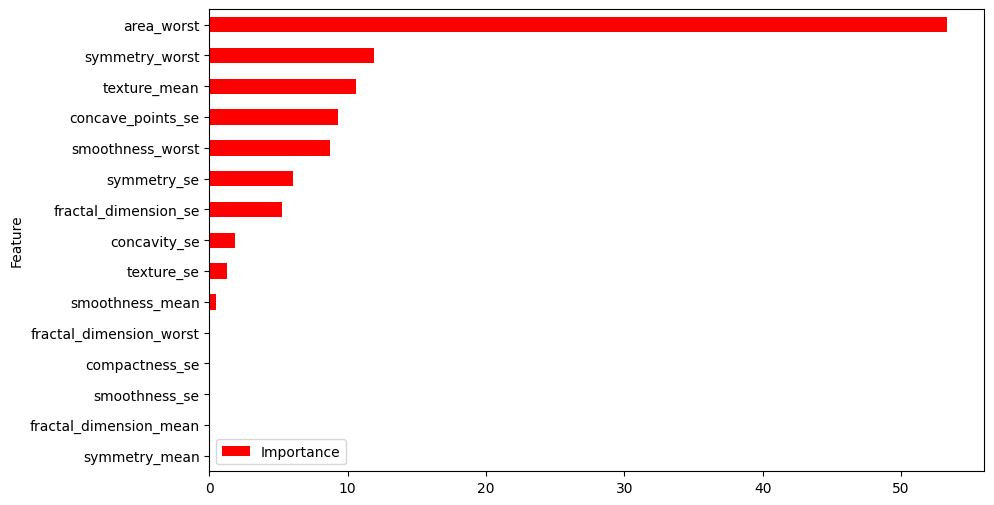

In [144]:
coefficients = log_reg_best.coef_[0]

feature_importance = pd.DataFrame({'Feature': train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

The "area_worst" feature is clearly the feature that drives the classification in this model, followed by symmetry_worst, texture_mean, concave_points_se. This means that the total area of the breast tumore is the best indicator of malignant/benign diagnosis with this model.

## Random Forest with hyperparameters tuning

In [145]:
# Set the parameters dictionary
parameters = {'n_estimators': [10,50,100,200], 
              'criterion':['gini', 'entropy'], 
              'max_depth':[1,2,3],
             'min_samples_split':[2,3],
             'min_samples_leaf':[1,2]}

# Instantiate the model and classifier
random_forest = RandomForestClassifier()
clf_rf = GridSearchCV(random_forest, parameters)

# Fit
clf_rf.fit(train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [10, 50, 100, 200]})

In [146]:
# Get the best estimator values
clf_rf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_split=3,
                       n_estimators=200)

In [147]:
clf_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200}

In [148]:
# Get the corresponding accuracy
clf_rf.best_score_

0.9706734867860188

Here we get the best results according to GridSearchCV on the training dataset with n_estimators=100, criterion='gini', max_depth=3, min_samples_split=3 and min_samples_leaf=1. We can check the corresponding AUC with the validation dataset.

In [149]:
random_forest_best = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, min_samples_split=3, min_samples_leaf=1)
random_forest_best.fit(train, y_train)

predicted_val_rf = random_forest_best.predict(val)
roc_auc_score(y_val, predicted_val_rf)

0.9516233766233765

The ROC AUC score on validation dataset is very close to the score on training dataset: there is little chance that the model is overfitting. We can confirm the stability of the model with k-fold cross-validation.

In [150]:
scores = []

for train_idx, val_idx in kfold.split(full_train):
    df_train_kfold = full_train.iloc[train_idx]
    df_val_kfold = full_train.iloc[val_idx]

    y_train_kfold = df_train_kfold["diagnosis"]
    y_val_kfold = df_val_kfold["diagnosis"]

    feature_list = df_train_kfold.columns.values.tolist()
    feature_list.remove("diagnosis")

    model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, min_samples_split=3, min_samples_leaf=1)
    model.fit(df_train_kfold, y_train_kfold)
    y_pred_kfold = model.predict(df_val_kfold)

    auc = roc_auc_score(y_val_kfold, y_pred_kfold)
    scores.append(auc)

print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

1.000 +- 0.000


The standard deviation of ROC AUC scores is equal to 0 after running 5-fold cross-validation on our dataset, which means that our model is very stable. We can check the ROC AUC value obtained with the test dataset, which will be used to select the best model among the three tested models.

In [151]:
predicted_test_rf = random_forest_best.predict(test)
rf_roc_auc = roc_auc_score(y_test, predicted_test_rf)
rf_roc_auc

0.9464461185718964

Finally, for explainability, we can check the feature importances with this model.

<Axes: ylabel='Feature'>

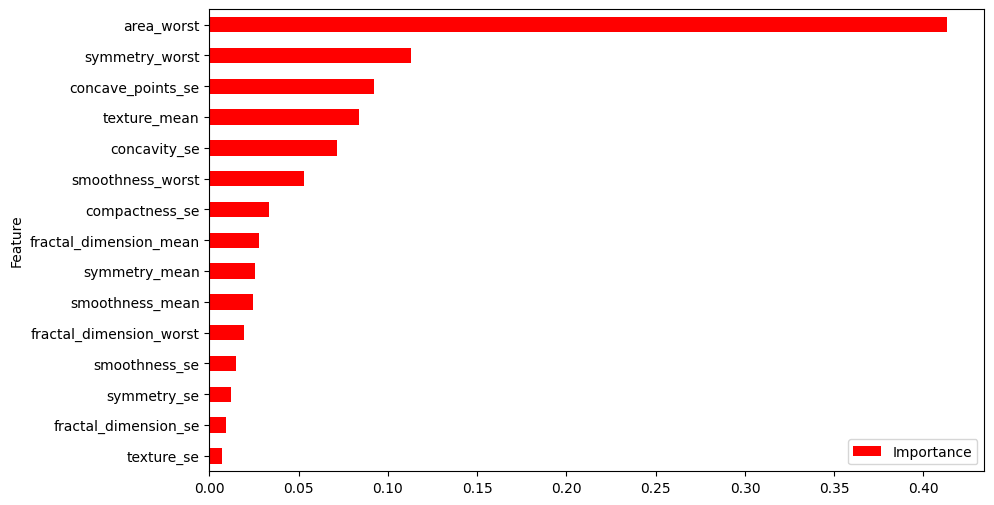

In [152]:
feature_importance = pd.DataFrame({'Feature': train.columns, 'Importance': random_forest_best.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

As with the Logistic Regression model, the area_worst feature is the most important for Random Forest Classifier. It is followed by the concavity_se, texture_mean and concave_points_se.

## XGBoost with hyperparameters tuning

In [153]:
# Set the parameters dictionary
parameters = {'eta':[0.3,0.5,0.7], 
              'max_depth':[1,2,3,4],
             'min_child_weight':[1,2,3,10,15],
             'objective':['binary:logistic']}

# Instantiate the model and classifier
xgb_classifier = XGBClassifier()
clf_xgb = GridSearchCV(xgb_classifier, parameters)

# Fit
clf_xgb.fit(train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.3, 0.5, 0.7], 'max_depth': [1, 2, 3, 4],
                         'min_child_weight': [1, 2, 3, 10, 15],
                         'objective': ['binary:logistic']})

In [154]:
# Get the best estimator values
clf_xgb.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [155]:
clf_xgb.best_params_

{'eta': 0.5,
 'max_depth': 3,
 'min_child_weight': 1,
 'objective': 'binary:logistic'}

In [156]:
# Get the corresponding accuracy
clf_xgb.best_score_

0.9619352088661552

Here we get the best results according to GridSearchCV on the training dataset with eta=0.5, max_depth=3 and min_child_weight=1. We can check the corresponding AUC with the validation dataset.

In [157]:
xgboost_best = XGBClassifier(eta=0.5, max_depth=3, min_child_weight=1)
xgboost_best.fit(train, y_train)

predicted_val_xgb = xgboost_best.predict(val)
roc_auc_score(y_val, predicted_val_xgb)

0.9444805194805195

The ROC AUC score on validation dataset is very close to the score on training dataset: there is little chance that the model is overfitting. We can confirm the stability of the model with k-fold cross-validation.

In [158]:
scores = []

for train_idx, val_idx in kfold.split(full_train):
    df_train_kfold = full_train.iloc[train_idx]
    df_val_kfold = full_train.iloc[val_idx]

    y_train_kfold = df_train_kfold["diagnosis"]
    y_val_kfold = df_val_kfold["diagnosis"]

    feature_list = df_train_kfold.columns.values.tolist()
    feature_list.remove("diagnosis")

    model = XGBClassifier(eta=0.5, max_depth=3, min_child_weight=1)
    model.fit(df_train_kfold, y_train_kfold)
    y_pred_kfold = model.predict(df_val_kfold)

    auc = roc_auc_score(y_val_kfold, y_pred_kfold)
    scores.append(auc)

print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

1.000 +- 0.000


The standard deviation of ROC AUC scores is equal to 0 after running 5-fold cross-validation on our dataset, which means that our model is very stable. We can check the ROC AUC value obtained with the test dataset, which will be used to select the best model among the three tested models.

In [159]:
predicted_test_xgb = xgboost_best.predict(test)
xgb_roc_auc = roc_auc_score(y_test, predicted_test_xgb)
xgb_roc_auc

0.9697019325253848

Finally, for explainability, we can check the feature importances with this model.

<Axes: ylabel='Feature'>

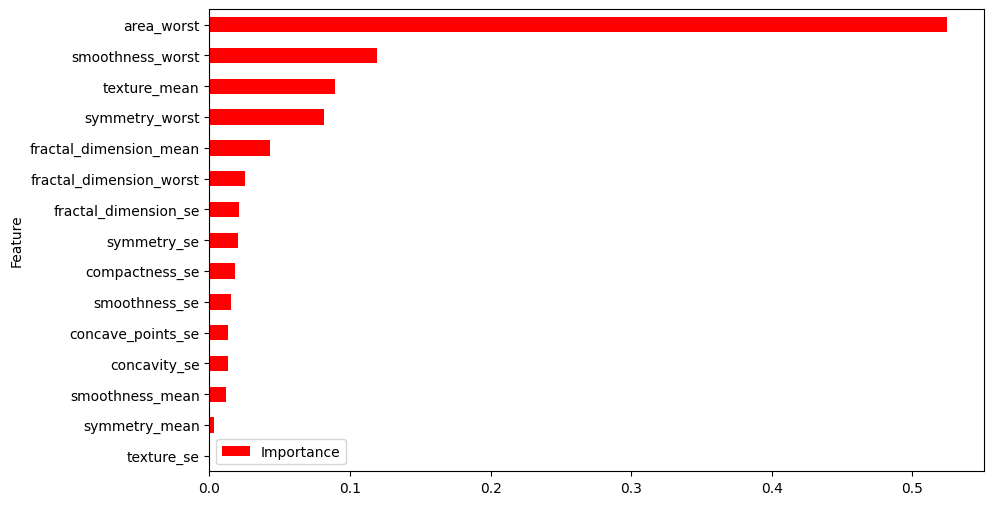

In [160]:
feature_importance = pd.DataFrame({'Feature': train.columns, 'Importance': xgboost_best.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

As for the Logistic Regression and the Random Forest Classifier models, the feature that drives the classification the most is area_worst. For this model, it is followed by smoothness_worst, texture_mean and symmetry_worst.

## Best model selection

The best model is selected based on the ROC AUC value obtained with the test dataset.

In [161]:
roc_auc_dict = {'dummy': dummy_roc_auc, 'LogisticRegression': log_reg_roc_auc, 'RandomForestClassifier': rf_roc_auc, 'XGBoostClassifier': xgb_roc_auc}

In [163]:
roc_auc_dict

{'dummy': 0.5,
 'LogisticRegression': 0.981329839502129,
 'RandomForestClassifier': 0.9464461185718964,
 'XGBoostClassifier': 0.9697019325253848}

The best ROC AUC value is obtained with the Logistic Regression model. This model will be used for deployment.